# Market Intelligence for GenAI Partnerships
### **Objective:** Use data-driven insights to identify and evaluate GenAI startups in India and Australia, understand their focus areas, and assess potential partnership opportunities for Dell.

In [ ]:
# Installing required libraries
! pip install fake_useragent selenium webdriver_manager urllib3 transformers torch PyPDF2 --quiet
! pip install selenium --quiet

In [1]:
# Importing libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
import os
import random
from fake_useragent import UserAgent
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import WebDriverException, TimeoutException
import warnings
import urllib3

import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import json

from collections import Counter
from huggingface_hub import InferenceClient
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from PyPDF2 import PdfReader

## 1. Introduction
This notebook analyzes GenAI startups in India and Australia to uncover trends, technological focus areas, and business models. The goal is to provide actionable insights for Dell to explore potential collaborations.

### Key Steps:
1. Data Preprocessing: Clean and prepare startup data for analysis. The data extraction has been done using the `data_extraction.py` python script and stored with-in the data folder.

2. Landscape Mining: Extract industry, technology, and business model tags.

3. Comparative Analysis: Visualize differences between Indian and Australian startups.

In [3]:
from huggingface_hub import login
from dotenv import load_dotenv
from pathlib import Path

current_dir = Path().resolve()
env_path = current_dir / "data" / ".env"

load_dotenv(dotenv_path=env_path)

api = os.getenv('API')
login(api)

## 2. Text Pre-Processing
### Overview
- Load datasets for Indian (indian_startups.csv) and Australian (australian_startups.csv) startups.
- Clean and standardize text data (e.g., remove HTML tags, URLs, and stopwords).

In [4]:
df_ind = pd.read_csv('data/indian_startups.csv', encoding="ISO-8859-1")
df_aus = pd.read_csv('data/australian_startups.csv', encoding="ISO-8859-1")

In [ ]:
def preprocess_text(df, column_name):
    
    # Downloading NLTK resources
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('wordnet')

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        if pd.isna(text):
            return ""

        text = text.lower()
        # Remove HTML tags
        text = re.sub(r"\s+", " ", text)  # normalize whitespace
        text = re.sub(r"http\S+", "", text)  # remove URLs
        text = re.sub(r"[^A-Za-z0-9.,;:()\[\]!?/\s]", "", text)  # remove unusual characters
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        return ' '.join(words)

    df[column_name] =  df[column_name].apply(clean_text)

    return df

In [6]:
df_ind = preprocess_text(df_ind, 'content')
df_aus = preprocess_text(df_aus, 'content')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]    

In [7]:
df_ind.head()

,domain_name,company_name,url,content
0,acuration.com,Acuration,['https://www.acuration.com/'],"unlock datadriven insight , synergy , instant ..."
1,ai4bharat.iitm.ac.in,Ai4bharat,"['https://ai4bharat.iitm.ac.in/', 'https://ai4...",home area transliteration machine translation ...
2,alphaa.ai,Alphaa,"['https://www.alphaa.ai/', 'https://www.alphaa...",super ai solution salesforce imply druid resou...
3,arocomsolutions.com,"Arocom IT Solutions Pvt Ltd - Experts in AI, C...","['https://www.arocomsolutions.com/', 'https://...",solving matter supercharge business transforma...
4,axtr.in,Axtr,['https://axtr.in/'],service expertise get touch transform saas age...


## 3. Startup Landscape Mining
### Key Tasks:
1. Tag Extraction: Use KeyBERT to identify key phrases.

2. Zero-Shot Classification: Categorize startups into:
    - Industries (Healthcare, Finance, etc.)
    - Tech Stack (NLP, Computer Vision, etc.)
    - Use Case Labels (Chatbots, Content Creation, etc.)
    - Business Models (B2B, SaaS, etc.)

In [8]:
# First we will use KeyBERT for phrase extraction and then zero-shot classification
from keybert import KeyBERT

# Inititalise models
kw_model = KeyBERT(model='sentence-transformers/all-mpnet-base-v2')
zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use cpu


In [ ]:
def extract_and_classify(text, labels, top_n=5):
    # Extracts keywords and classifies into predefined labels
    try:
        keywords = [kw for kw, _ in kw_model.extract_keywords(text, top_n=top_n)]
        joined_keywords = ". ".join(keywords) if keywords else text
        result = zero_shot(joined_keywords, candidate_labels=labels)
        return result['labels'][:3], dict(zip(result['labels'], result['scores']))
    except Exception as e:
        return "Unknown", {}


In [ ]:
# Define candidate labels
industry_labels = [
    "Healthcare", "Finance", "Retail", "Manufacturing", "Transportation",
    "Education", "Legal", "Agriculture", "Media & Entertainment", "Energy",
    "Real Estate", "HR & Recruitment", "Cybersecurity"
]

tech_labels = [
    "Natural Language Processing", "Computer Vision", "Generative AI",
    "Machine Learning", "Reinforcement Learning", "Speech Recognition",
    "Predictive Analytics", "Robotics", "Edge AI", "Synthetic Data",
    "Federated Learning"
]

use_case_labels = [
    "Chatbots", "Fraud Detection", "Recommendation Systems", "Medical Imaging",
    "Process Automation", "Predictive Maintenance", "Content Creation",
    "Sentiment Analysis", "Supply Chain Optimization", "Personalized Learning"
]

business_model_labels = [
    "B2B", "B2C", "B2G", "SaaS", "API-as-a-Service", "Consulting",
    "Product and Services"
]

In [ ]:
def apply_landscape_mining(df):
    df['industry_tag'], df['industry_scores'] = zip(*df['content'].apply(lambda x: extract_and_classify(str(x), industry_labels)))
    df['tech_stack_tag'], df['tech_stack_scores'] = zip(*df['content'].apply(lambda x: extract_and_classify(str(x), tech_labels)))
    df['use_case_tag'], df['use_case_scores'] = zip(*df['content'].apply(lambda x: extract_and_classify(str(x), use_case_labels)))
    df['business_model_tag'], df['business_model_scores'] = zip(*df['content'].apply(lambda x: extract_and_classify(str(x), business_model_labels)))
    return df


In [12]:
df_ind = apply_landscape_mining(df_ind)
df_aus = apply_landscape_mining(df_aus)

## 4. Filtering GenAI Startups
### Criteria:
Startups are flagged as GenAI if "Generative AI" appears in their tech_stack_tag.

In [13]:
## Filtering out GenAI startups

# For India startups
genai_ind = df_ind[df_ind['tech_stack_tag'].apply(lambda tags: "Generative AI" in tags)].reset_index(drop=True)

# For Australia startups
genai_aus = df_aus[df_aus['tech_stack_tag'].apply(lambda tags: "Generative AI" in tags)].reset_index(drop=True)


In [42]:
genai_aus.head()

,domain_name,company_name,url,content,industry_tag,industry_scores,tech_stack_tag,tech_stack_scores,use_case_tag,use_case_scores,business_model_tag,business_model_scores,revenue_model_tag,revenue_model_scores,customer_segment_tag,customer_segment_scores
0,akin.com,Akin,"['https://www.akin.com/', 'http://akin.com/our...",ethos technology solution health frontier ai g...,"[Energy, Legal, Education]","{'Energy': 0.5267007350921631, 'Legal': 0.0811...","[Edge AI, Generative AI, Synthetic Data]","{'Edge AI': 0.20855623483657837, 'Generative A...","[Personalized Learning, Sentiment Analysis, Re...","{'Personalized Learning': 0.2362777292728424, ...","[B2C, B2B, B2G]","{'B2C': 0.21142958104610443, 'B2B': 0.18607507...","[Freemium, Subscription, Enterprise Contracts]","{'Freemium': 0.28360432386398315, 'Subscriptio...","[Enterprise, Developers, Startups]","{'Enterprise': 0.7389337420463562, 'Developers..."
1,archistar.ai,Archistar,"['https://www.archistar.ai/', 'https://www.arc...",ai research platform government solution indus...,"[Legal, Energy, Agriculture]","{'Legal': 0.2569723427295685, 'Energy': 0.1133...","[Edge AI, Synthetic Data, Generative AI]","{'Edge AI': 0.18225738406181335, 'Synthetic Da...","[Recommendation Systems, Content Creation, Per...",{'Recommendation Systems': 0.21381379663944244...,"[B2C, B2G, B2B]","{'B2C': 0.22698917984962463, 'B2G': 0.21985875...","[Subscription, Freemium, Pay-per-use]","{'Subscription': 0.3457958400249481, 'Freemium...","[Enterprise, SMEs, Startups]","{'Enterprise': 0.24039575457572937, 'SMEs': 0...."
2,arnowa.com,Arnowa Smart Technology and Intelligence,"['https://arnowa.com/', 'https://arnowa.com/ab...",please click redirected within second . home p...,"[Transportation, Energy, Legal]","{'Transportation': 0.1878977119922638, 'Energy...","[Robotics, Synthetic Data, Generative AI]","{'Robotics': 0.17284229397773743, 'Synthetic D...","[Personalized Learning, Recommendation Systems...","{'Personalized Learning': 0.23987019062042236,...","[B2C, B2G, B2B]","{'B2C': 0.19639380276203156, 'B2G': 0.17848867...","[Freemium, Subscription, Licensing]","{'Freemium': 0.27911806106567383, 'Subscriptio...","[Developers, Enterprise, Startups]","{'Developers': 0.3744548559188843, 'Enterprise..."
3,cigen.com.au,CiGen,"['https://www.cigen.com.au/our-solutions/#ai',...",aipowered business solution cigen offer compre...,"[Energy, Legal, Education]","{'Energy': 0.27333173155784607, 'Legal': 0.101...","[Robotics, Federated Learning, Generative AI]","{'Robotics': 0.18650807440280914, 'Federated L...","[Recommendation Systems, Process Automation, P...","{'Recommendation Systems': 0.2906981110572815,...","[API-as-a-Service, B2G, Consulting]","{'API-as-a-Service': 0.42471739649772644, 'B2G...","[Freemium, Subscription, Licensing]","{'Freemium': 0.3825530707836151, 'Subscription...","[Developers, Startups, Enterprise]","{'Developers': 0.2922976613044739, 'Startups':..."
4,daisee.com,daisee,"['https://www.daisee.com/about/#our-story', 'h...",daisee australian ai provider supporting leadi...,"[Energy, Legal, Transportation]","{'Energy': 0.2021690160036087, 'Legal': 0.1222...","[Robotics, Generative AI, Federated Learning]","{'Robotics': 0.22963948547840118, 'Generative ...","[Chatbots, Personalized Learning, Recommendati...","{'Chatbots': 0.8217313885688782, 'Personalized...","[SaaS, B2G, Consulting]","{'SaaS': 0.5027522444725037, 'B2G': 0.12849356...","[Subscription, Freemium, Pay-per-use]","{'Subscription': 0.36653435230255127, 'Freemiu...","[Developers, Startups, Enterprise]","{'Developers': 0.34995022416114807, 'Startups'..."


In [ ]:
# genai_aus.to_csv('data/genai_aus.csv', index=False)
# genai_ind.to_csv('data/genai_ind.csv', index=False)

## 5. Comparative Analysis
### Visualizations:
1. Industry Distribution: Compare top industries in India vs. Australia.
2. Tech Stack Trends: Highlight dominant technologies.

In [ ]:
def get_country_score_df(score_dicts, country_name):
    """Aggregates score dictionaries into a country-specific DataFrame.
    
    Args:
        score_dicts: List of dictionaries containing label-score pairs
        country_name: Name of country to label the data
        
    Returns:
        DataFrame with columns: Label, Score, Country
    """
    # Aggregate scores across all dictionaries
    agg_scores = {}
    for d in score_dicts:
        for k, v in d.items():
            agg_scores[k] = agg_scores.get(k, 0) + v  # Sum scores for each label
            
    return pd.DataFrame({
        'Label': list(agg_scores.keys()),
        'Score': list(agg_scores.values()), 
        'Country': country_name
    })

def plot_comparative_scores(ind_scores, aus_scores, title, top_n=10, palette='Set2'):
    """Creates a comparative bar plot of scores between India and Australia.
    
    Args:
        ind_scores: List of score dictionaries for India
        aus_scores: List of score dictionaries for Australia  
        title: Plot title
        top_n: Number of top labels to show
        palette: Color palette for the plot
    """
    # Create country-specific DataFrames
    df_ind = get_country_score_df(ind_scores, 'India')
    df_aus = get_country_score_df(aus_scores, 'Australia')

    # Combine both country DataFrames
    df_combined = pd.concat([df_ind, df_aus])

    # Get top N labels based on combined scores
    top_labels = (df_combined.groupby("Label")["Score"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(top_n).index)
    df_combined = df_combined[df_combined["Label"].isin(top_labels)]

    # Create plot
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(
        data=df_combined, 
        y="Score", 
        x="Label", 
        hue="Country", 
        palette=palette
    )

    # Improve label readability
    plt.xticks(rotation=45)
    
    # Add score values on bars
    for container in ax.containers:
        ax.bar_label(
            container, 
            fmt='%.2f',  # Format to 2 decimal places
            label_type='edge',  # Position labels at bar ends
            padding=2  # Small offset from bars
        )

    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Total Score (Sum of Probabilities)", fontsize=12)
    plt.legend(title="Country")
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

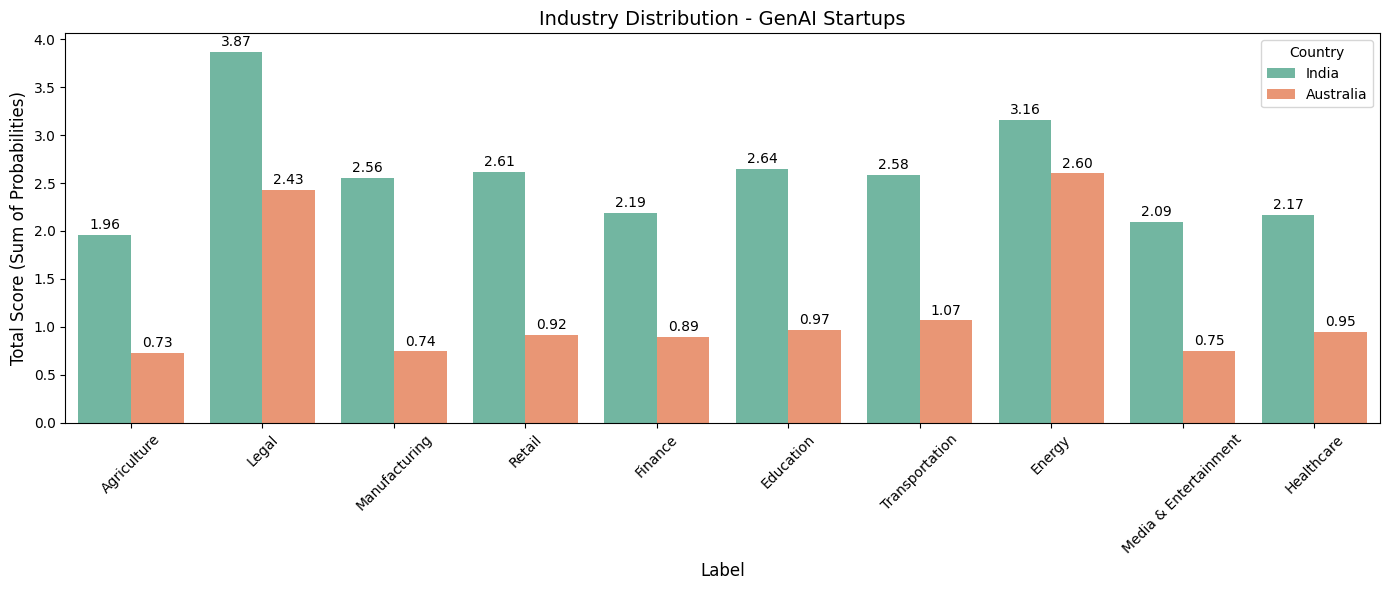

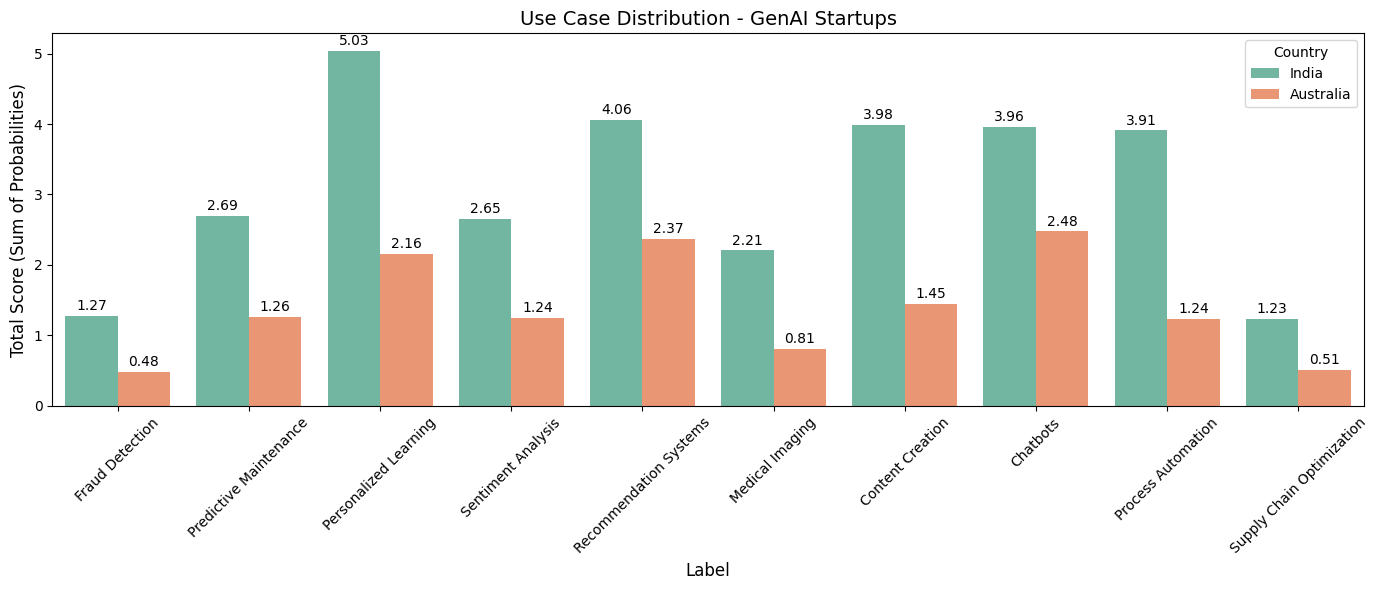

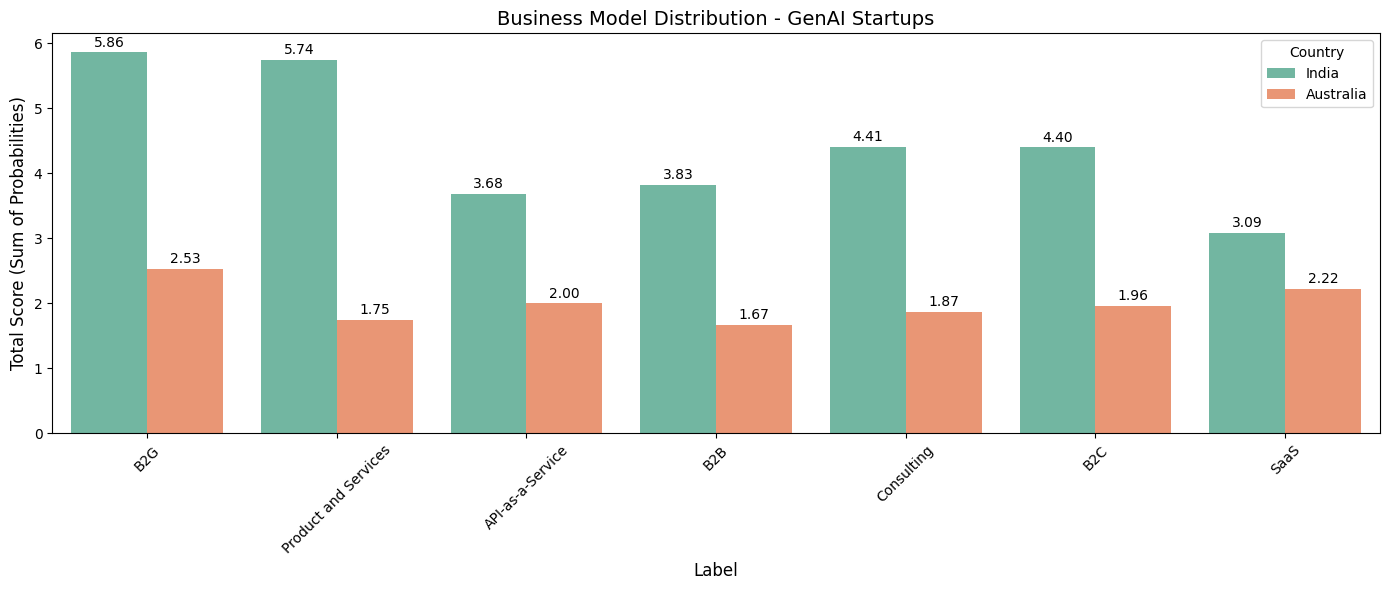

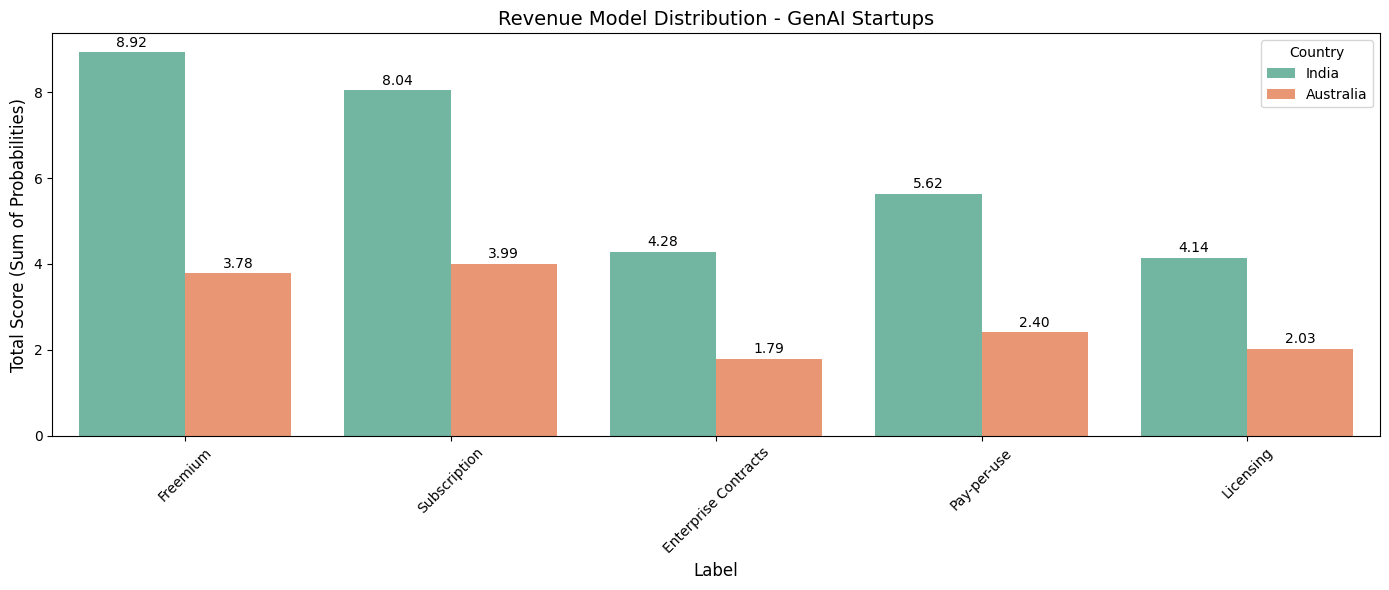

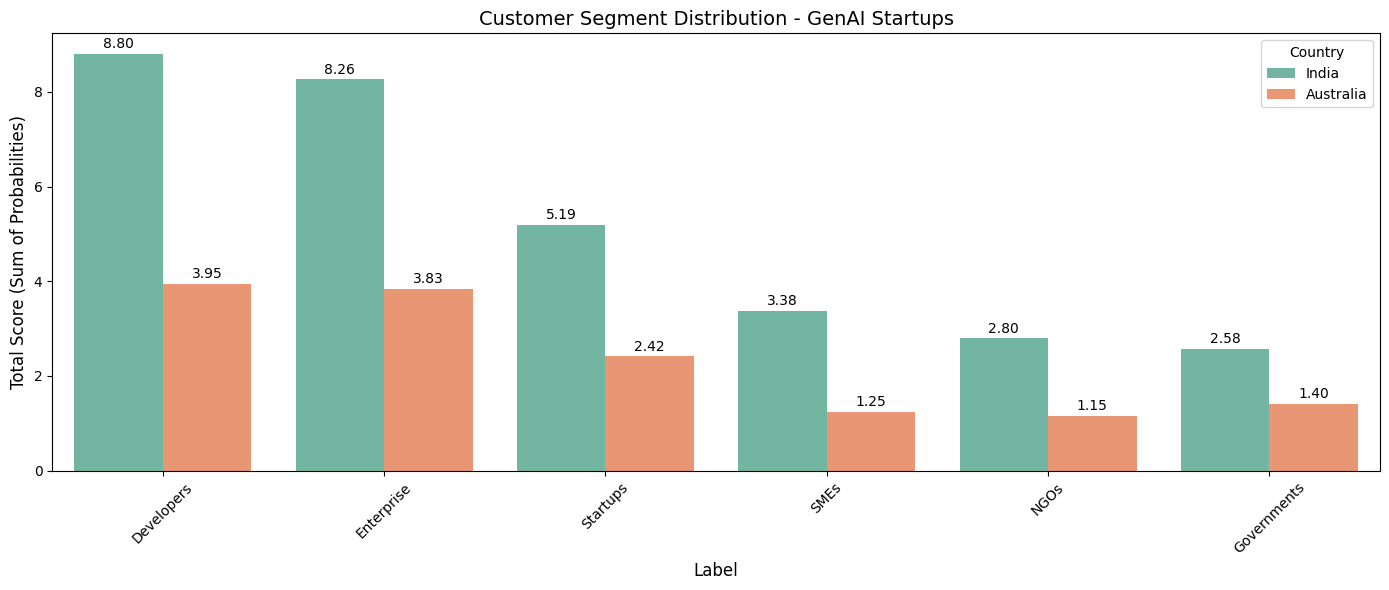

In [22]:
plot_comparative_scores(genai_ind['industry_scores'], genai_aus['industry_scores'], "Industry Distribution - GenAI Startups")
plot_comparative_scores(genai_ind['use_case_scores'], genai_aus['use_case_scores'], "Use Case Distribution - GenAI Startups")
plot_comparative_scores(genai_ind['business_model_scores'], genai_aus['business_model_scores'], "Business Model Distribution - GenAI Startups")
plot_comparative_scores(genai_ind['revenue_model_scores'], genai_aus['revenue_model_scores'], "Revenue Model Distribution - GenAI Startups")
plot_comparative_scores(genai_ind['customer_segment_scores'], genai_aus['customer_segment_scores'], "Customer Segment Distribution - GenAI Startups")


## 6. Synergy Identification for Dell

We will start by extracting data about Dell to figure out synergy areas

In [ ]:
# Initialize Selenium with headless Chrome configuration
def setup_selenium():
    """Initialize Selenium with proper configurations"""
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run browser in background
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")  # Avoid detection
    chrome_options.add_argument("--no-sandbox")  # Required for some environments
    chrome_options.add_argument("--disable-dev-shm-usage")  # Prevent resource issues
    chrome_options.page_load_strategy = 'eager'  # Faster loading by not waiting for all resources

    # Set up ChromeDriver service
    service = Service(
        ChromeDriverManager().install(),  # Auto-install ChromeDriver
        port=0  # Use any available port
    )

    # Create driver instance with configured options
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.set_page_load_timeout(30)  # Page load timeout
    driver.set_script_timeout(30)  # Script execution timeout
    return driver

# Fetch URL with retry logic for reliability
def fetch_with_retry(driver, url, retries=1):
    """Attempt to fetch URL with retry mechanism"""
    for attempt in range(retries + 1):
        try:
            driver.get(url)
            wait_time = random.uniform(2, 6)  # Random delay to appear human
            time.sleep(wait_time)
            return driver.page_source  # Return HTML content if successful
        except Exception as e:
            print(f"Attempt {attempt+1} failed for {url}: {type(e).__name__} - {e}")
            if attempt == retries:
                return None  # Return None after final attempt

# Load URLs from text file
with open("data/dell.txt", "r", encoding='utf-8') as f:
    urls = [line.strip() for line in f if line.strip()]  # Read and clean URLs

# Initialize browser and data container
driver = setup_selenium()
scraped_data = []  # Store scraped results

# Process each URL
for url in urls:
    try:
        # Fetch page with retry and random delay
        html = fetch_with_retry(driver, url, retries=1)
        
        if html:  # Only process if fetch succeeded
            # Verify page is ready
            driver.execute_script("return document.readyState;")
            
            # Extract page title
            title = driver.title
            
            # Try to get meta description
            meta_desc = None
            try:
                meta_desc = driver.find_element(By.XPATH, '//meta[@name="description"]').get_attribute("content")
            except:
                pass  # Meta description not found
            
            # Store scraped data
            scraped_data.append({
                "company_name": 'Dell',  # Hardcoded for Dell
                "url": url,  # Original URL
                "content": meta_desc  # Extracted meta description
            })
            
            print(f"Scraped: {url} (waited {wait_time:.2f}s)")
            
    except Exception as e:
        print(f"Error scraping {url}: {type(e).__name__} - {e}")
        # Store failed attempt with null content
        scraped_data.append({
            "company_name": 'Dell',
            "url": url,
            "content": None
        })

# Clean up browser instance
driver.quit()

# Save results to CSV
dell_df = pd.DataFrame(scraped_data)
dell_df.to_csv("data/dell.csv", index=False)  # Save without index column

Scraped: https://www.delltechnologies.com/partner/en-in/partner/modern-workplace.htm (waited 4.31s)
Scraped: https://www.delltechnologies.com/partner/en-in/partner/modern-infrastructure.htm (waited 2.50s)
Scraped: https://www.delltechnologies.com/partner/en-in/partner/artificial-intelligence.htm (waited 2.58s)
Scraped: https://www.delltechnologies.com/partner/en-in/partner/discovery-center.htm (waited 5.48s)
Scraped: https://www.delltechnologies.com/partner/en-in/partner/partner.htm (waited 5.38s)
Scraped: https://www.delltechnologiescapital.com/ (waited 4.31s)
Scraped: https://www.dell.com/en-in/lp/dt/technologies-and-tools (waited 5.41s)
Scraped: https://www.dell.com/en-in/lp/dt/training-and-certification (waited 5.30s)
Scraped: https://www.dell.com/en-in/lp/dt/lifecycle-services (waited 3.91s)
Scraped: https://www.dell.com/en-in/lp/dt/professional-services (waited 3.09s)
Scraped: https://www.dell.com/en-in/lp/dt/innovate-with-services (waited 4.41s)
Scraped: https://www.dell.com/en-

In [ ]:
# Scraping Dell data from PDFs and saving to CSV

# Set paths for PDF folder and output CSV file
pdf_folder = "data"
csv_path = os.path.join(pdf_folder, "dell.csv")

# Function to extract text content from PDF files
def extract_pdf_text(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        text = ""
        # Extract text from each page
        for page in reader.pages:
            text += page.extract_text() or ""
        return text.strip()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None

# Get list of all PDF files in the folder
pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith(".pdf")]

# Process each PDF and collect extracted data
new_rows = []
for pdf_file in pdf_files:
    pdf_path = os.path.join(pdf_folder, pdf_file)
    content = extract_pdf_text(pdf_path)
    if content:  # Only add if text extraction succeeded
        new_rows.append({
            "company_name": "Dell",  # Hardcoded since we're only processing Dell docs
            "url": None,  # PDFs don't have URLs
            "content": content  # Extracted text content
        })

# Create DataFrame from extracted data
pdf = pd.DataFrame(new_rows)

# Check if existing CSV exists and append/create accordingly
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pdf], ignore_index=True)
else:
    updated_df = pdf

# Save the combined data to CSV
updated_df.to_csv(csv_path, index=False)
print(f"✅ Appended {len(new_rows)} PDF entries to {csv_path}")

✅ Appended 2 PDF entries to data\dell.csv


In [61]:
# Reading the updated dataframe
dell_df = pd.read_csv('data/dell.csv')

In [ ]:
# Preprocessing the content column for dell_df
dell_df = preprocess_text(dell_df, 'content')

In [62]:
# Drop rows where 'content' is empty or NaN
cleaned_df = dell_df[dell_df["content"].notna() & (dell_df["content"].str.strip() != "")]

In [63]:
cleaned_df

,company_name,url,content
0,Dell,https://www.delltechnologies.com/partner/en-in...,With the security and performance provided by ...
1,Dell,https://www.delltechnologies.com/partner/en-in...,"Design and implement a smart, flexible and res..."
2,Dell,https://www.delltechnologies.com/partner/en-in...,Accelerate intelligent outcomes everywhere wit...
3,Dell,https://www.delltechnologies.com/partner/en-in...,Explore all our latest launches and find the c...
4,Dell,https://www.delltechnologies.com/partner/en-in...,Dell Technologies Partner Portal - sign in to ...
5,Dell,https://www.delltechnologiescapital.com/,Leading early-stage investments in the compani...
13,Dell,https://www.dell.com/en-in/dt/business-pcs-lap...,"Transform your workspace with Dell PCs, monito..."
14,Dell,https://www.dell.com/en-in/dt/apex/device/pc-a...,Dell APEX PC as a Service (PCaaS) is a complet...
23,Dell,https://www.dell.com/en-in/dt/apex/index.htm?h...,Learn how Dell Technologies APEX as-a-service ...
32,Dell,https://www.dell.com/en-in/dt/apex/index.htm#E...,Learn how Dell Technologies APEX as-a-service ...


In [ ]:
from keybert import KeyBERT

# Initialize KeyBERT with mpnet model for keyword extraction
kw_model = KeyBERT(model='sentence-transformers/all-mpnet-base-v2')

# Combine all Dell content into single string for processing
dell_corpus = " ".join(cleaned_df['content'].dropna().tolist())

# Extract top 25 keywords representing Dell's capabilities
dell_keywords = [kw for kw, _ in kw_model.extract_keywords(dell_corpus, top_n=25)]
print("Dell Keywords:\n", dell_keywords)


Dell Keywords:
 ['delltechnologies', 'dell', 'intel', 'processors', 'services2industry', 'pcaas', 'technologies', 'ai', 'pcs', 'cloud', 'hardware', 'services', 'multicloud', 'platforms', 'scalability', 'technology', 'automation', 'platform', 'workloads', 'security', 'multicloudquickly', 'pc', 'monitors', 'insightstm', 'vpro']


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Initialize the Sentence Transformer model
# 'all-MiniLM-L6-v2' is a pre-trained model that balances speed and performance
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert Dell's capability keywords into vector embeddings
dell_embeddings = model.encode(dell_keywords, convert_to_tensor=True)

In [ ]:
def compute_synergy_score(startup_tags, dell_keywords, model):
    """
    Computes the synergy score between a startup and Dell based on keyword similarity.

    Args:
    - startup_tags (list of str): Tags from the startup (e.g. tech stack, use case, etc.)
    - dell_keywords (list of str): Extracted keywords representing Dell's capabilities
    - model (SentenceTransformer): Pretrained embedding model

    Returns:
    - float: Mean of the maximum cosine similarity scores between startup tags and Dell capabilities
    """

    # Convert startup tags to embeddings
    startup_embeddings = model.encode(startup_tags, convert_to_tensor=True)

    # Convert Dell keywords to embeddings
    dell_embeddings = model.encode(dell_keywords, convert_to_tensor=True)

    # Compute cosine similarity between each startup tag and each Dell keyword
    scores = util.cos_sim(startup_embeddings, dell_embeddings)

    # For each startup tag, find the highest similarity score (best match with Dell)
    max_scores = scores.max(dim=1).values.cpu().numpy()

    # Return the average of these best match scores as the synergy score
    return max_scores.mean()


In [72]:
def combined_tags(row):
    tags = []
    for col in ['tech_stack_tag', 'use_case_tag', 'industry_tag']:
        tags.extend(row[col] if isinstance(row[col], list) else [row[col]])
    return tags

In [74]:
df_ind['synergy_score'] = df_ind.apply(lambda row: compute_synergy_score(combined_tags(row), dell_keywords, model), axis=1)
df_aus['synergy_score'] = df_aus.apply(lambda row: compute_synergy_score(combined_tags(row), dell_keywords, model), axis=1)

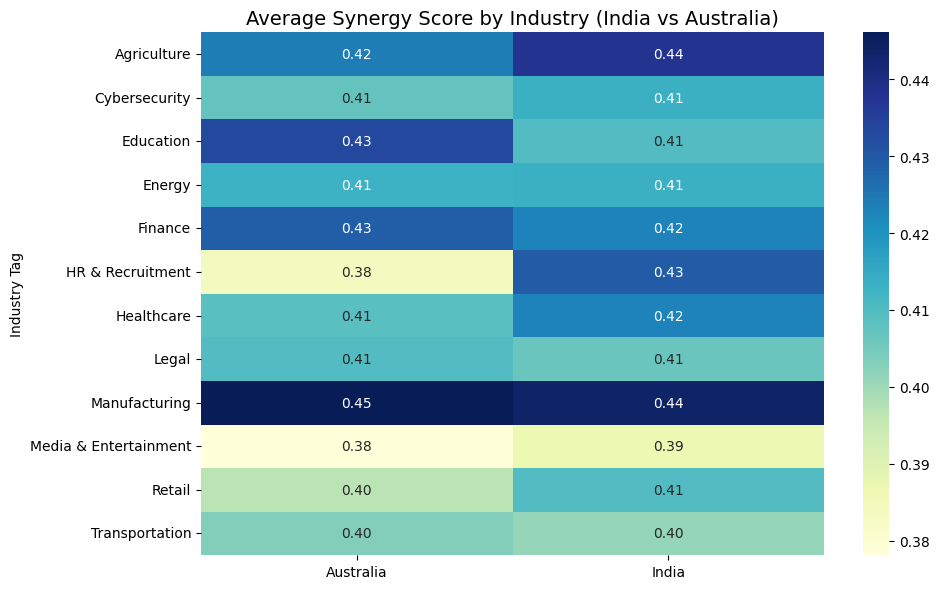

In [ ]:
def plot_synergy_heatmap(df_ind, df_aus):
    """
    Visualizes average synergy scores by industry for Indian and Australian startups using a heatmap.
    
    Args:
        df_ind (DataFrame): Indian startups data containing 'industry_tag' and 'synergy_score'
        df_aus (DataFrame): Australian startups data containing 'industry_tag' and 'synergy_score'
    """
    
    # Explode industry_tag lists into multiple rows (one row per tag per startup)
    # This transforms lists like ['Healthcare', 'Finance'] into separate rows
    df_ind_exp = df_ind.explode('industry_tag')
    df_aus_exp = df_aus.explode('industry_tag')

    # Combine both country datasets with exploded tags
    # Add Country column to identify the source of each row
    df_combined = pd.concat([
        df_ind_exp[['industry_tag', 'synergy_score']].assign(Country='India'),
        df_aus_exp[['industry_tag', 'synergy_score']].assign(Country='Australia')
    ])

    # Clean data by removing any rows with missing or empty industry tags
    df_combined = df_combined.dropna(subset=['industry_tag'])

    # Calculate mean synergy score for each industry-country combination
    # Results in DataFrame with columns: industry_tag, Country, synergy_score (mean)
    df_grouped = df_combined.groupby(['industry_tag', 'Country'])['synergy_score'].mean().reset_index()

    # Pivot the data to create a matrix suitable for heatmap visualization
    # Rows: industry_tags
    # Columns: Countries (India/Australia)
    # Values: mean synergy scores (filled with 0 if no data exists)
    heatmap_data = df_grouped.pivot(index='industry_tag', columns='Country', values='synergy_score').fillna(0)

    # Create the heatmap visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True,        # Display the numerical values in each cell
        cmap="YlGnBu",     # Use Yellow-Green-Blue color gradient
        fmt=".2f",         # Format numbers to 2 decimal places
        linewidths=0.5     # Add thin borders between cells
    )
    
    # Add chart title and axis labels
    plt.title("Average Synergy Score by Industry (India vs Australia)", fontsize=14)
    plt.xlabel("")  # Empty x-label since country is obvious from column headers
    plt.ylabel("Industry Tag")
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# Execute the function with the Indian and Australian startup data
plot_synergy_heatmap(df_ind, df_aus)

### Key Insights from the Data
1. Highest Synergy Scores
    - Manufacturing leads in both countries (India: 0.45, Australia: 0.44).
    - Agriculture and Finance also show strong alignment (scores ≥ 0.42).

2. Competitive Advantages
India outperforms Australia in:
    - Manufacturing (0.45 vs 0.44)
    - Education (0.43 vs 0.41)
    - Finance (0.43 vs 0.42)

Australia leads in:
    - HR & Recruitment (0.43 vs 0.38)
    - Healthcare (0.42 vs 0.41)

3. Neutral Industries
- Cybersecurity, Energy, Legal, and Transportation have nearly identical scores (~0.41), suggesting equal partnership potential.

4. Lower-Synergy Sectors
- Media & Entertainment has the lowest scores (India: 0.38, Australia: 0.39), indicating weaker alignment.

### Why This Matters
- Strategic Partnerships: Dell could prioritize Manufacturing and Finance collaborations in India, while exploring HR and Healthcare opportunities in Australia.

- Balanced Markets: Neutral industries like Cybersecurity offer flexible collaboration options in either country.

***Note: Synergy scores (0–1 scale) measure compatibility between Dell’s capabilities and industry needs. Higher values indicate stronger alignment.***



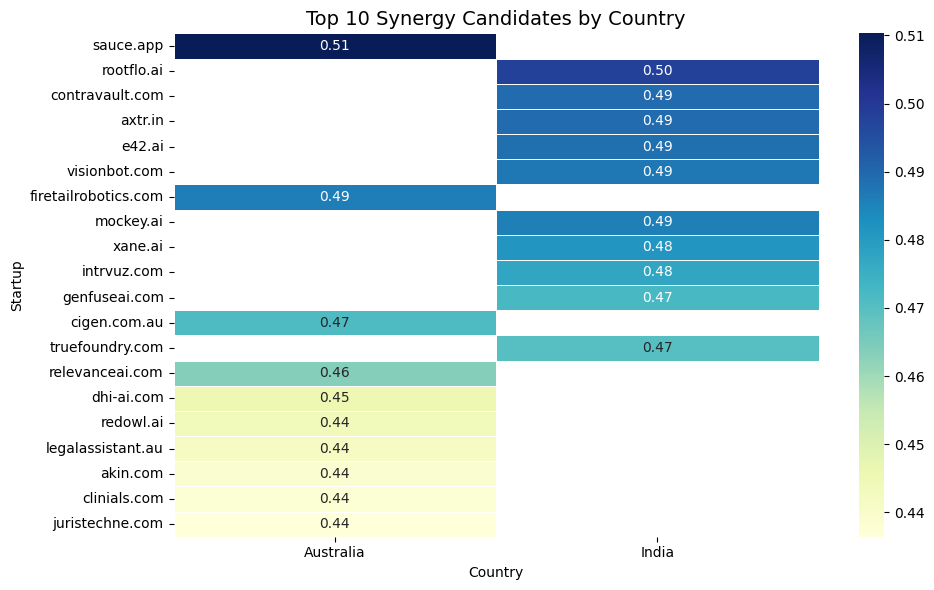

In [89]:
def top_synergy_candidates(df, country_name, top_n=10):
    """
    Identifies top startups with highest synergy scores for a given country.
    
    Args:
        df (DataFrame): Input dataframe containing startup data
        country_name (str): Name of country to label results
        top_n (int): Number of top startups to return (default: 10)
    
    Returns:
        DataFrame: Top startups with selected columns and country label
    """
    # Sort by synergy_score in descending order and take top_n rows
    top_startups = df.sort_values(by='synergy_score', ascending=False).head(top_n)
    
    # Return selected columns with country label added
    return top_startups[['company_name', 'industry_tag', 'tech_stack_tag', 
                        'synergy_score', 'domain_name']].assign(Country=country_name)

# Get top startups for India and Australia
top_ind = top_synergy_candidates(df_ind, "India")
top_aus = top_synergy_candidates(df_aus, "Australia")

# Combine results from both countries
top_combined = pd.concat([top_ind, top_aus])

def plot_top_synergy_candidates_heatmap(top_combined):
    """
    Creates a heatmap visualization of top synergy candidates by country.
    
    Args:
        top_combined (DataFrame): Combined data of top startups from multiple countries
    """
    # Create pivot table with:
    # - Rows: domain_name (startup websites)
    # - Columns: Country
    # - Values: synergy_score
    heatmap_df = top_combined.pivot(index='domain_name', columns='Country', values='synergy_score')

    # Sort rows by maximum synergy score (descending order)
    heatmap_df = heatmap_df.loc[heatmap_df.max(axis=1).sort_values(ascending=False).index]

    # Create heatmap plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_df, 
        annot=True,       # Show values in cells
        cmap='YlGnBu',    # Yellow-Orange-Red color palette
        fmt=".2f",        # Format values to 2 decimal places
        linewidths=0.5     # Add thin borders between cells
    )
    
    # Add plot labels and formatting
    plt.title("Top 10 Synergy Candidates by Country", fontsize=14)
    plt.xlabel("Country")
    plt.ylabel("Startup")
    plt.tight_layout()    # Prevent label cutoff
    plt.show()

# Generate the heatmap visualization
plot_top_synergy_candidates_heatmap(top_combined)

In [91]:
top_ind

,company_name,industry_tag,tech_stack_tag,synergy_score,domain_name,Country
54,Rootflo,"[Finance, Manufacturing, Legal]","[Edge AI, Synthetic Data, Generative AI]",0.498182,rootflo.ai,India
10,ContraVault,"[Legal, Retail, Manufacturing]","[Reinforcement Learning, Federated Learning, E...",0.489516,contravault.com,India
4,Axtr,"[Legal, Transportation, Healthcare]","[Federated Learning, Generative AI, Edge AI]",0.489349,axtr.in,India
16,E42,"[Energy, Manufacturing, Transportation]","[Edge AI, Natural Language Processing, Robotics]",0.488644,e42.ai,India
70,"Enterprise Automation, Visual Monitoring and I...","[Agriculture, Manufacturing, Legal]","[Robotics, Computer Vision, Generative AI]",0.487038,visionbot.com,India
40,Mockey,"[Manufacturing, Media & Entertainment, Retail]","[Generative AI, Edge AI, Robotics]",0.485675,mockey.ai,India
75,Xane AI,"[Transportation, Retail, Legal]","[Generative AI, Edge AI, Federated Learning]",0.481422,xane.ai,India
32,Intrvuz,"[HR & Recruitment, Legal, Education]","[Robotics, Generative AI, Synthetic Data]",0.477606,intrvuz.com,India
20,Genfuseai,"[Energy, Transportation, Healthcare]","[Robotics, Federated Learning, Generative AI]",0.472266,genfuseai.com,India
67,Truefoundry,"[Legal, Transportation, Education]","[Computer Vision, Federated Learning, Generati...",0.470126,truefoundry.com,India


In [92]:
top_aus

,company_name,industry_tag,tech_stack_tag,synergy_score,domain_name,Country
38,Sauce,"[Finance, Manufacturing, Legal]","[Edge AI, Machine Learning, Robotics]",0.510311,sauce.app,Australia
18,Firetail,"[Transportation, Legal, Education]","[Robotics, Synthetic Data, Edge AI]",0.485794,firetailrobotics.com,Australia
9,CiGen,"[Energy, Legal, Education]","[Robotics, Federated Learning, Generative AI]",0.471360,cigen.com.au,Australia
35,Relevanceai,"[Legal, Agriculture, Cybersecurity]","[Federated Learning, Synthetic Data, Generativ...",0.463402,relevanceai.com,Australia
16,Dhi-ai,"[Energy, Education, Healthcare]","[Synthetic Data, Edge AI, Generative AI]",0.445263,dhi-ai.com,Australia
34,Redowl,"[Finance, Legal, Agriculture]","[Edge AI, Generative AI, Synthetic Data]",0.443625,redowl.ai,Australia
25,Legalassistant,"[Legal, Energy, Education]","[Edge AI, Federated Learning, Robotics]",0.441705,legalassistant.au,Australia
3,Akin,"[Energy, Legal, Education]","[Edge AI, Generative AI, Synthetic Data]",0.438925,akin.com,Australia
10,Clinials,"[Healthcare, Legal, Energy]","[Edge AI, Federated Learning, Synthetic Data]",0.438014,clinials.com,Australia
24,juristechne.com,"[Legal, Transportation, Healthcare]","[Edge AI, Generative AI, Synthetic Data]",0.436409,juristechne.com,Australia
